In [1]:
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def update_path(source_path, new_path_prefix):
    filename = source_path.split('/')[-1]
    return new_path_prefix + filename

driving_log = pd.read_csv('data/driving_log.csv')

In [2]:
num_in = len(driving_log)
X_train = np.zeros((6*num_in, 160, 320, 3), dtype=np.uint8)
y_train = np.zeros(6*num_in, dtype=float)


for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['center'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    X_train[2*i] = image
    y_train[2*i] = steering_angle
    X_train[2*i+1] = np.fliplr(image)
    y_train[2*i+1] = -steering_angle
    
for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['left'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    steering_angle += 0.25
    X_train[2*num_in + 2*i] = image
    y_train[2*num_in + 2*i] = steering_angle
    X_train[2*num_in + 2*i+1] = np.fliplr(image)
    y_train[2*num_in + 2*i+1] = -steering_angle
    
for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['right'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    steering_angle -= 0.25
    X_train[4*num_in + 2*i] = image
    y_train[4*num_in + 2*i] = steering_angle
    X_train[4*num_in + 2*i+1] = np.fliplr(image)
    y_train[4*num_in + 2*i+1] = -steering_angle
    

In [15]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Input, Cropping2D, Dropout, Activation, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG19, VGG16, InceptionV3, ResNet50

save_path = 'model.h5'

dropout_rate = 0.4
crop_top = 60
crop_bottom = 20
split_left_right = 140
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=3)
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)

def high_value_emphasizing_loss(y_true, y_pred):
    weighted_squared_difference = (y_true - y_pred)**2 * (1 + 100*np.abs(y_true)) # what if true = 0?
    return weighted_squared_difference

pretrained = VGG16(weights='imagenet', include_top=False,
                   input_shape=(160-crop_top-crop_bottom, 320-0, 3))
for layer in pretrained.layers:
    layer.trainable = False
    
# pretrained_cut = Sequential()  # https://github.com/tensorflow/tensorflow/issues/22479
# for layer in pretrained.layers[:-4]:
#     pretrained_cut.add(layer)


# common_dense_layer = Dense(128)

# def sidewise_block(input_tensor):
#     x = Lambda(lambda x: (x / 255.0) - 0.5)(input_tensor)
#     x = pretrained(x)
#     x = Flatten()(x)
#     x = Dropout(rate=dropout_rate)(x)
#     x = Dense(128)(x)
#     x = Activation('relu')(x)
#     return x

# inp = Input(shape=(160,320,3))
# left = Cropping2D(cropping=((crop_top,crop_bottom), (0,split_left_right)))(inp)
# right = Cropping2D(cropping=((crop_top,crop_bottom), (split_left_right,0)))(inp)
# left = sidewise_block(left)
# right = sidewise_block(right)
# x = Concatenate(axis=1)([left, right])
# x = Dropout(rate=dropout_rate)(x)
# x = Dense(128)(x)
# x = Activation('relu')(x)
# x = Dropout(rate=dropout_rate)(x)
# out = Dense(1)(x)
# model = Model(inputs = inp, outputs=out)

inp = Input(shape=(160,320,3))
x = Cropping2D(cropping=((crop_top,crop_bottom), (0,0)))(inp)
x = Lambda(lambda x: (x / 255.0) - 0.5)(x)
x = pretrained(x)
x = Flatten()(x)
x = Dropout(rate=0.4)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
model = Model(inputs = inp, outputs=x)

model.compile(loss=high_value_emphasizing_loss, optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=30,
                           batch_size=256, callbacks=[stopper, checkpoint])


Train on 38572 samples, validate on 9644 samples
Epoch 1/30
38572/38572 [==============================] - 73s 2ms/step - loss: 5.8346 - val_loss: 3.6170
Epoch 2/30
38572/38572 [==============================] - 72s 2ms/step - loss: 1.7912 - val_loss: 3.6171
Epoch 3/30
38400/38572 [============================>.] - ETA: 0s - loss: 1.5771

KeyboardInterrupt: 

In [ ]:
Train on 38572 samples, validate on 9644 samples
Epoch 1/30
38572/38572 [==============================] - 72s 2ms/step - loss: 9.4782 - val_loss: 0.9563
Epoch 2/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.8008 - val_loss: 0.9083
Epoch 3/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.6067 - val_loss: 0.8420
Epoch 4/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.5146 - val_loss: 0.8828
Epoch 5/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.4510 - val_loss: 0.8305
Epoch 6/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.4133 - val_loss: 0.8329
Epoch 7/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.3839 - val_loss: 0.9468
Epoch 8/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.3650 - val_loss: 0.7558
Epoch 9/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.3518 - val_loss: 0.8261
Epoch 10/30
38572/38572 [==============================] - 72s 2ms/step - loss: 0.3352 - val_loss: 0.7706
Epoch 11/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.3356 - val_loss: 0.7865


In [9]:
model.compile(loss='mse', optimizer='adam')
model.save('model_30_custom_loss.h5')

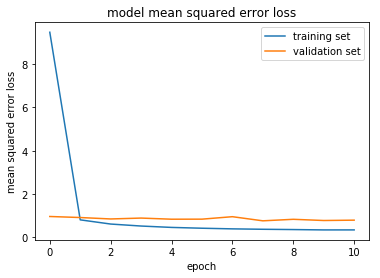

In [14]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [25]:
pretrained = VGG16(weights='imagenet', include_top=False,
                   input_shape=(160-crop_top-crop_bottom, 320-split_left_right, 3))
pre = Sequential()
for layer in pretrained.layers[:-8]: # just exclude last layer from copying
    pre.add(layer)

In [27]:
pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 80, 180, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 180, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 45, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 20, 45, 256)       295168    
__________

In [28]:
pre.save('test_p.h5')